# Segmenting and Clustering Neighborhoods in Toronto


### Let's start process of clustering of the neighbordhoods in Toronto
#### I will mainly repeat analysis we have done in the lab for NY data. I have experimented with the queries a bit (e.g. radius), but looks like radius of 500 m makes sense, otherwise there is overlap between areas.

In [7]:
#!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas import json_normalize
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#! pip install folium==0.5.0
import folium # plotting library

#### I will hide my api data

In [8]:
CLIENT_ID = 'XXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXX' # your Foursquare Secret
ACCESS_TOKEN = 'XXXXXXX' # your FourSquare Access Token
VERSION = '20210427'
LIMIT = 30

In [9]:
# Define function that retrieves venues for neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
radius=500
# Getting data on venues from all neighborhoods of Toronto
toronto_venues = getNearbyVenues(df_merged.Neighborhood, df_merged.Latitude, df_merged.Longitude, radius)

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [11]:
toronto_venues.shape
toronto_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Towns On The Ravine,43.754754,-79.332552,Hotel
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
5,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
6,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
7,"Regent Park, Harbourfront",43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
8,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
9,"Regent Park, Harbourfront",43.654260,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center


In [12]:
toronto_venues.groupby('Neighborhood').count().Venue

Neighborhood
Agincourt                                           4
Alderwood, Long Branch                              8
Bathurst Manor, Wilson Heights, Downsview North    21
Bayview Village                                     4
Bedford Park, Lawrence Manor East                  22
                                                   ..
Willowdale West                                     5
Willowdale, Newtonbrook                             1
Woburn                                              3
Woodbine Heights                                   10
York Mills West                                     2
Name: Venue, Length: 99, dtype: int64

In [13]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 239 uniques categories.


#### Data Wrangling is almost identical to the NY lab

In [14]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()
toronto_onehot.shape

(1322, 239)

In [15]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,"Willowdale, Newtonbrook",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0


In [ ]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Breakfast Spot,Skating Rink,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Sandwich Place,Pub,Skating Rink,Playground,Medical Center,Mediterranean Restaurant,Modern European Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Park,Ice Cream Shop,Shopping Mall,Sandwich Place,Middle Eastern Restaurant,Mobile Phone Shop,Supermarket,Restaurant
3,Bayview Village,Café,Chinese Restaurant,Bank,Japanese Restaurant,Movie Theater,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Italian Restaurant,Sandwich Place,Indian Restaurant,Sushi Restaurant,Juice Bar,Café,Butcher,Pub,Thai Restaurant


In [18]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop(['Neighborhood'], 1)


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32)

In [19]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_merged

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

# Let's drop row where cluster is NaN
print(toronto_merged.shape)
toronto_merged.dropna(axis=0, inplace=True)
print(toronto_merged.shape)

(103, 16)
(99, 16)


In [20]:
toronto_merged["Cluster Labels"] = toronto_merged["Cluster Labels"].astype('int')
toronto_merged.head()
toronto_merged.drop('PostalCode', axis=1)

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,1,Park,Hotel,Food & Drink Shop,Yoga Studio,Monument / Landmark,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store
1,North York,Victoria Village,43.725882,-79.315572,0,Portuguese Restaurant,Coffee Shop,Hockey Arena,French Restaurant,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Motel,Mexican Restaurant
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Park,Bakery,Café,Breakfast Spot,Pub,Chocolate Shop,Dessert Shop,Restaurant,Distribution Center
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0,Clothing Store,Furniture / Home Store,Coffee Shop,Miscellaneous Shop,Carpet Store,Arts & Crafts Store,Boutique,Vietnamese Restaurant,Accessories Store,Organic Grocery
4,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,Yoga Studio,Sandwich Place,Fried Chicken Joint,Beer Bar,Smoothie Shop,Mexican Restaurant,Burrito Place,Café
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944,1,Park,River,Yoga Studio,Monument / Landmark,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store
99,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0,Sushi Restaurant,Coffee Shop,Thai Restaurant,Salon / Barbershop,Restaurant,Beer Bar,Bookstore,Park,Ramen Restaurant,Breakfast Spot
100,East Toronto Business,Enclave of M4L,43.662744,-79.321558,0,Light Rail Station,Yoga Studio,Auto Workshop,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Park,Comic Shop,Pizza Place
101,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,4,Baseball Field,Yoga Studio,Lounge,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant


In [21]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Plotting clusters

In [89]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Results analysis
It is clear that one cluster dominates clustering. Let's see what clusters are like. I will check which venues are the most common in every cluster. I will select top 4 most common types.


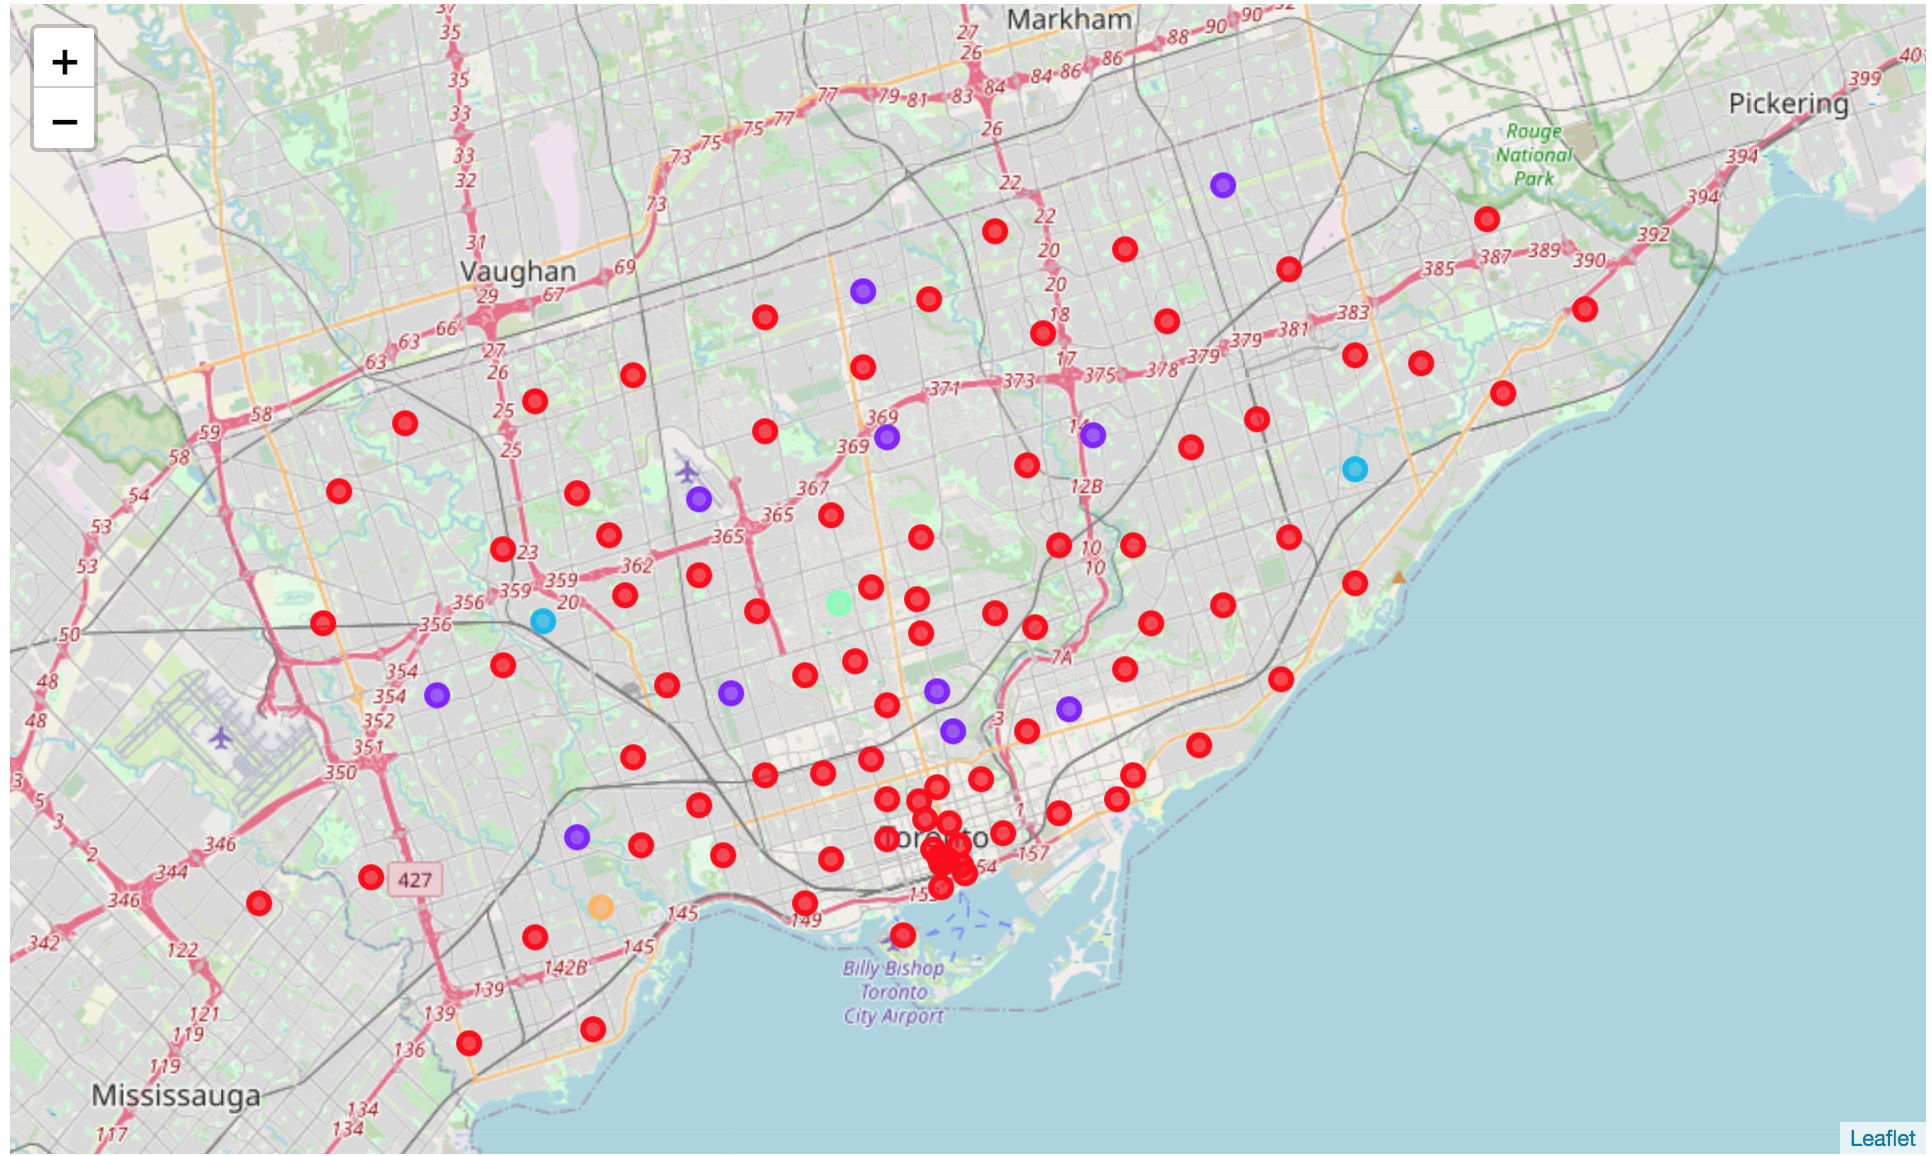

In [87]:
#import matplotlib.pyplot as plt
top10 = pd.DataFrame()
clusters = 5
for clu in range(clusters):  # loop over clusters
    cluster = toronto_merged.loc[toronto_merged['Cluster Labels'] == clu, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
    values, counts = np.unique(cluster.iloc[:,2:6].values, return_counts=True)  #selecting from top 4 most occuring venues
    top10_clus=sorted(zip(counts, values),reverse=True)[:10]  # select top 10 count of frequent venues
    colname1 = 'Cluster_' + str(clu) + ' venue'
    colname2 = 'Cluster_' + str(clu) + ' count'
    top10[colname1] = pd.DataFrame(top10_clus)[1]
    top10[colname2] = pd.DataFrame(top10_clus)[0]

#### Let's see what are the top 10 venues (amount top top four most frequent ones)

In [88]:
top10.head(10)

,Cluster_0 venue,Cluster_0 count,Cluster_1 venue,Cluster_1 count,Cluster_2 venue,Cluster_2 count,Cluster_3 venue,Cluster_3 count,Cluster_4 venue,Cluster_4 count
0,Coffee Shop,33,Park,11,Yoga Studio,2.0,Yoga Studio,1.0,Yoga Studio,1.0
1,Café,22,Yoga Studio,10,Motel,2.0,Monument / Landmark,1.0,Martial Arts School,1.0
2,Pizza Place,15,Monument / Landmark,5,Convenience Store,2.0,Market,1.0,Lounge,1.0
3,Yoga Studio,12,Playground,2,Playground,1.0,Garden,1.0,Baseball Field,1.0
4,Park,10,Market,2,Martial Arts School,1.0,NaN,NaN,NaN,NaN
5,Bakery,10,Intersection,2,NaN,NaN,NaN,NaN,NaN,NaN
6,Gym,9,Convenience Store,2,NaN,NaN,NaN,NaN,NaN,NaN
7,Sandwich Place,7,Women's Store,1,NaN,NaN,NaN,NaN,NaN,NaN
8,Restaurant,7,Trail,1,NaN,NaN,NaN,NaN,NaN,NaN
9,Bank,7,Sandwich Place,1,NaN,NaN,NaN,NaN,NaN,NaN


#### Cluster 0
Unsurprisingly, most common venues in cluster 0 are coffee shops, cafes, pizza places, yoga studioes, parks, gyms etc - typical types of venues that people like to go to. Typical urban neighborhoods. 

#### Cluster 1
Most common venues in top 4 most frequent types of venues are parks, yoga studios, landmarks, playgrounds, markets. We can see that it differs a lot from cluster 0. Indeed, visual inspection shows that these neighborhoods have parks in the vicinity, and they take up space. Therefore lower building density and fewer services operating within them.

#### Cluster 2
This cluster clearly differs from cluster 0 and 1 - top venues are yoga studio, motels, convenience stores, playgrounds and martial arts schools.

#### Cluster 3  
There is only one neighborhods in this cluster - and not surprisingly. Most common venues are yoga studies, monuments, market and garden. Minimal overlap with previous clusters - this is a residential area.

#### Cluster 4
This cluster is potentially physically dominated by baseball field (which takes a lot of space in the area). I can zoom to the map and see that this neighborhood is very subruban, with private houses, which means low population density in comparison with downtown. Such district can not support small business because there are not enough customers. So not a surprising result.